In [1]:
import os
import random

import numpy as np
import pandas as pd
import gc
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from google.colab import files

In [2]:
os.environ['KAGGLE_USERNAME'] = "karthikrrao" # username from the json file
os.environ['KAGGLE_KEY'] = "f1be2589607428bfd1e9f1f023d4f660" # key from the json file
!

In [ ]:
#!pip install -q kaggle
#!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6
!kaggle -v

In [ ]:
!kaggle competitions download -c data-science-bowl-2018

In [ ]:
!unzip /content/stage1_test.zip -d /content/test

In [ ]:
!unzip /content/stage1_train.zip -d /content/train

In [7]:
"""
  Prepare train set and test set.
"""

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
width_out = 128
height_out = 128
TRAIN_PATH = '/content/train/'
TEST_PATH = '/content/test/'

seed = 42
random.seed = seed
np.random.seed = seed

name_train = os.listdir(TRAIN_PATH)
name_test = os.listdir(TEST_PATH)
x_train = np.zeros((len(name_train),IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS), dtype = np.uint8)
y_train = np.zeros((len(name_train),IMG_HEIGHT,IMG_WIDTH,1), dtype = np.bool)

for i in range(len(name_train)):
  current_images = TRAIN_PATH + name_train[i] + '/images/'
  current_masks = TRAIN_PATH + name_train[i] + '/masks/'
  temp = os.listdir(current_images)
  img = imread(current_images + temp[0])[:,:,:IMG_CHANNELS]
  img = resize(img,(IMG_HEIGHT, IMG_WIDTH),mode = 'constant', preserve_range=True)
  x_train[i] = img
  mask = np.zeros((height_out, width_out,1), dtype = np.bool)
  for mask_file in next(os.walk(current_masks))[2]:
    mask_ = imread(current_masks + mask_file)
    mask_ = np.expand_dims(resize(mask_,(height_out, width_out), mode = 'constant', preserve_range=True),axis=-1)
    mask = np.maximum(mask,mask_)
  y_train[i] = mask 

In [8]:
x_test = np.zeros((len(name_test),IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS), dtype = np.uint8)
sizes_test = []
for i in range(len(name_test)):
  current_images = TEST_PATH + name_test[i] + '/images/'
  temp = os.listdir(current_images)
  img = imread(current_images + temp[0])[:,:,:IMG_CHANNELS]
  sizes_test.append([img.shape[0], img.shape[1]])
  img = resize(img,(IMG_HEIGHT, IMG_WIDTH),mode = 'constant', preserve_range=True)
  x_test[i] = img

In [9]:
print(x_train.shape, y_train.shape, x_test.shape)

(670, 128, 128, 3) (670, 128, 128, 1) (65, 128, 128, 3)


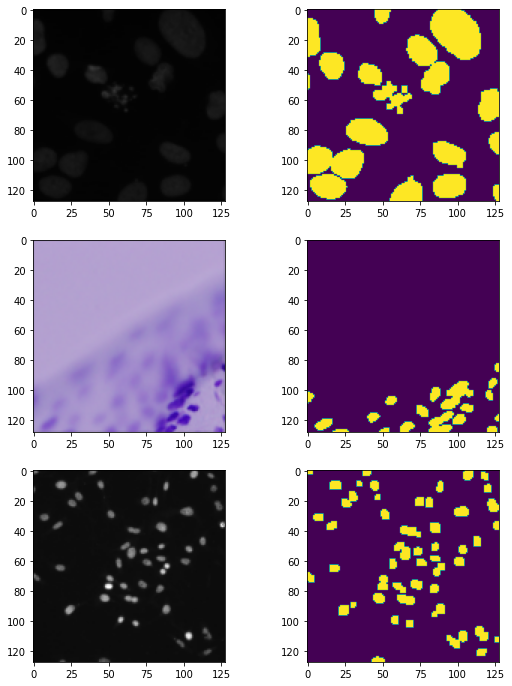

In [10]:
"""
  Display some train images with masks.
"""

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(9,12))
ax[0][0].imshow(x_train[0])
ax[0][1].imshow(np.squeeze(y_train[0]))
ax[1][0].imshow(x_train[1])
ax[1][1].imshow(np.squeeze(y_train[1]))
ax[2][0].imshow(x_train[2])
ax[2][1].imshow(np.squeeze(y_train[2]))

In [11]:
x_train, x_val, y_train, y_val =  train_test_split(x_train, y_train, test_size=0.25)

In [12]:
x_train = x_train.transpose((0,3,1,2))
y_train = y_train.transpose((0,3,1,2))
x_val = x_val.transpose((0,3,1,2))
y_val = y_val.transpose((0,3,1,2))
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(502, 3, 128, 128) (502, 1, 128, 128) (168, 3, 128, 128) (168, 1, 128, 128)


In [13]:
"""
  Define model.
"""

use_gpu = torch.cuda.is_available()
class UNet(nn.Module):
  def contractingblock(self, in_channels, out_channels, kernel_size = 3):
    block = torch.nn.Sequential(
        torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=out_channels, padding=1),
        torch.nn.ReLU(),
        torch.nn.Dropout2d(),
        torch.nn.Conv2d(kernel_size=kernel_size, in_channels=out_channels, out_channels=out_channels, padding=1),
        torch.nn.ReLU(),
        torch.nn.BatchNorm2d(out_channels)
    )
    return block

  def expandingblock(self, in_channels, mid_channel, out_channels, kernel_size = 3):
    block = torch.nn.Sequential(
        torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel, padding=1),
        torch.nn.ReLU(),
        torch.nn.Dropout2d(),
        torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel, padding=1),
        torch.nn.ReLU(),
        torch.nn.BatchNorm2d(mid_channel),
        torch.nn.ConvTranspose2d(in_channels=mid_channel, out_channels=out_channels, kernel_size=3, stride=2, padding=1, output_padding=1)
    )
    return block

  def finalblock(self, in_channels, mid_channel, out_channels, kernel_size=3):
    block = torch.nn.Sequential(
        torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel, padding=1),
        torch.nn.ReLU(),
        torch.nn.Dropout2d(),
        torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel, padding=1),
        torch.nn.ReLU(),
        torch.nn.BatchNorm2d(mid_channel),
        torch.nn.Conv2d(in_channels=mid_channel, out_channels=out_channels, kernel_size=kernel_size, padding=1),
        torch.nn.Sigmoid()
    )
    return block

  def __init__(self, in_channel, out_channel):
    super(UNet, self).__init__()
    self.encode1 = self.contractingblock(in_channels=in_channel, out_channels=64)
    self.conv_maxpool1 = torch.nn.MaxPool2d(kernel_size=2)
    self.encode2 = self.contractingblock(in_channels=64, out_channels=128)
    self.conv_maxpool2 = torch.nn.MaxPool2d(kernel_size=2)
    self.encode3 = self.contractingblock(in_channels=128, out_channels=256)
    self.conv_maxpool3 = torch.nn.MaxPool2d(kernel_size=2)
    self.encode4 = self.contractingblock(in_channels=256, out_channels=512)
    self.conv_maxpool4 = torch.nn.MaxPool2d(kernel_size=2)

    self.bottleneck = torch.nn.Sequential(
        torch.nn.Conv2d(kernel_size=3, in_channels=512, out_channels=1024, padding=1),
        torch.nn.ReLU(),
        torch.nn.BatchNorm2d(1024),
        torch.nn.Conv2d(kernel_size=3, in_channels=1024, out_channels=1024, padding=1),
        torch.nn.ReLU(),
        torch.nn.BatchNorm2d(1024),
        torch.nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)   
    )

    self.conv_decode4 = self.expandingblock(1024, 512, 256)
    self.conv_decode3 = self.expandingblock(512, 256, 128)
    self.conv_decode2 = self.expandingblock(256, 128, 64)
    self.final_layer = self.finalblock(128, 64, out_channel)

  def crop_and_concat(self, upsampled, bypass, crop=False):
    if crop:
      c = (bypass.size()[2] - upsampled.size()[2]) // 2
      bypass = F.pad(bypass, (-c,-c,-c,-c))
    return torch.cat((upsampled,bypass),1)

  def forward(self, x):
    encode_block1 = self.encode1(x)
    encode_pool1 = self.conv_maxpool1(encode_block1)
    encode_block2 = self.encode2(encode_pool1)
    encode_pool2 = self.conv_maxpool2(encode_block2)
    encode_block3 = self.encode3(encode_pool2)
    encode_pool3 = self.conv_maxpool3(encode_block3)
    encode_block4 = self.encode4(encode_pool3)
    encode_pool4 = self.conv_maxpool4(encode_block4)
    bottleneck1 = self.bottleneck(encode_pool4)
    decode_block4 = self.crop_and_concat(bottleneck1, encode_block4, crop=True)
    cat_layer3 = self.conv_decode4(decode_block4)
    decode_block3 = self.crop_and_concat(cat_layer3, encode_block3, crop=True)
    cat_layer2 = self.conv_decode3(decode_block3)
    decode_block2 = self.crop_and_concat(cat_layer2, encode_block2, crop=True)
    cat_layer1 = self.conv_decode2(decode_block2)
    decode_block1 = self.crop_and_concat(cat_layer1, encode_block1, crop=True)
    final = self.final_layer(decode_block1)
    return final

In [14]:
batch_size = 64
epochs = 120
epoch_lapse = 20
threshold = 0.33
sample_size = None

In [15]:
def train_step(inputs, labels, optimizer, criterion, batch_size):
    optimizer.zero_grad()
    outputs = unet(inputs)
    #outputs.shape =(batch_size, n_classes, img_cols, img_rows)
    outputs = outputs.permute(0,2,3,1)
    #outputs.shape =(batch_size, img_cols, img_rows, n_classes) 
    outputs = outputs.reshape(batch_size*width_out*height_out, 2)
    labels = labels.reshape(batch_size*width_out*height_out)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    return loss

In [ ]:
learning_rate = 0.01
unet = UNet(in_channel=3, out_channel=2)
if use_gpu:
    unet = unet.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(unet.parameters(), lr = 0.01, momentum=0.99)
print(unet)

In [19]:
def get_val_loss(x_val, y_val, batch_size=batch_size):
  epoch_iter = np.ceil(x_val.shape[0] / batch_size).astype(int)
  for _ in range(epoch_iter):
    total_loss = 0
    for i in range(epoch_iter):
      batch_val_x = torch.from_numpy(x_val[i*batch_size:(i+1)*batch_size]).float()
      batch_val_y = torch.from_numpy(y_val[i*batch_size:(i+1)*batch_size].astype(int)).long()
      if use_gpu:
        batch_val_x = batch_val_x.cuda()
        batch_val_y = batch_val_y.cuda()
      m = batch_val_x.shape[0]
      outputs = unet(batch_val_x)
      outputs = outputs.permute(0,2,3,1)
      outputs = outputs.reshape(m*width_out*height_out, 2)
      labels = batch_val_y.reshape(m*width_out*height_out)
      loss = F.cross_entropy(outputs, labels)
      total_loss += loss.data
      gc.collect()
  return total_loss / epoch_iter    


In [ ]:
"""
  Training.
"""

epoch_iter = np.ceil(x_train.shape[0] / batch_size).astype(int)
for _ in range(epochs):
  total_loss=0
  for i in range(epoch_iter):
    batch_train_x = torch.from_numpy(x_train[i*batch_size:(i+1)*batch_size]).float()
    batch_train_y = torch.from_numpy(y_train[i*batch_size:(i+1)*batch_size].astype(int)).long()
    if use_gpu:
      batch_train_x = batch_train_x.cuda()
      batch_train_y = batch_train_y.cuda()
    batch_loss = train_step(batch_train_x, batch_train_y,optimizer, criterion,batch_train_x.shape[0])
    total_loss += batch_loss
    gc.collect()
  if (_+1)%epoch_lapse == 0:
    val_loss = get_val_loss(x_val, y_val)
    print(f'Total loss in epoch {_+1} : {total_loss/epoch_iter} and validation loss: {val_loss}')  

gc.collect()   

In [23]:
""" 
  Test the model on a sample from the test set.
"""


#x_test2
output_image = torch.empty(128,128,2).cuda()
input_image = torch.from_numpy(x_test[2])
input_image = torch.unsqueeze(input_image,0)
input_image = input_image.permute(0,3,1,2).float()
input_image = input_image.cuda()
print(input_image.shape)
unet = unet.eval()
output_image = unet(input_image)

torch.Size([1, 3, 128, 128])


torch.Size([1, 2, 128, 128]) (128, 128) (128, 128)


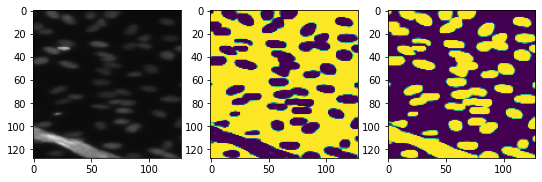

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(9,12))
final_image = output_image.detach().cpu().numpy()
final_image = np.squeeze(final_image)
output_image1 = final_image[0,:,:]
output_image2 = final_image[1,:,:]
ax[0].imshow(x_test[2])
ax[1].imshow(output_image1)
ax[2].imshow(output_image2)
print(output_image.shape, output_image1.shape, output_image2.shape)